## > Importing Liberaries && Some Function

In [1]:
import tensorflow as tf
from tensorflow.keras import losses , metrics , applications ,layers  , models , callbacks , optimizers 
tf.keras.backend.set_image_data_format('channels_last')

import numpy as np
import pandas as pd

import cv2
from PIL import Image, ImageEnhance

import matplotlib.pyplot as plt
plt.style.use("dark_background")
import seaborn as sn

import os , shutil
from shutil import copyfile

from tqdm import tqdm
from pprint import pprint
import  gc

import albumentations as A
import io

In [2]:
def display_images(List = None, Labels = None, size = 2,cmap = 'jet',grid=None , scaling =['unit','minmax'][0]):
    try:
        if(List!=None):
            n = len(List)
            
            if(grid==None):
                grid = (1,n)
                
            plt.figure(figsize = (size * grid[1], size*grid[0]))
            for i in range(n):
                plt.subplot(grid[0],grid[1],i+1)

                img  = List[i]
                img = np.array(img,dtype = np.float32)
                
                if(np.max(img)>1):
                    if(scaling == 'unit'):
                        # print('unit rescaling image')
                        img = img/255
                    else:
                        # print('min max rescaling image')
                        img = (img - img.min())/(img.max() - img.min())
                plt.imshow(img ,cmap = cmap)
                plt.axis('off')
                if(Labels != None):
                    plt.title(Labels[i],color = 'cyan')
            plt.show()
            
    except Exception as e:
        print('Error :',e)

In [3]:
History_dict = {}
Model_dict = {}

def add_to_model_dict(model ,model_name):
    if(model_name in Model_dict.keys()):
        print("model_already_there")
    else:
        Model_dict[model_name] = model

def add_to_history_dict(history ,model_name):
    if(model_name in History_dict.keys()):
        print("model_already_there")
    else:
        History_dict[model_name] = history

## > Loading Data

###  || Load Data from google drive 

In [4]:
# Model_dict

In [5]:
dataset_name = 'Drive'
# base_path = os.getcwd()+'/../input/'
base_path = ""

dataset_base_path = base_path+'datasets/'+dataset_name

In [6]:
preprocesses =[
    "> Clahe , smoothing , Edge Detection" ,
    "> Resizeing  & Resclaing",
    "> Random Contrast , sharpness, Brightness",
    "> Random  Zoom , Shift , Flip , Rotate90",
]

In [7]:
config ={
    'dataset' : {
        '_image_shape' : (576,544),
    },
    'model' : {
        
    },
    
    'training' : {
        
    },
    'preprocesing' : '\n'.join(preprocesses),
}

Model_names = [ 'simple_unet' ,'residual_unet' ,'recuurent_unet','r2_unet' , 'residual_attention_unet']

In [99]:
# Flow data from directories
train_images_path = dataset_base_path +  '/Data/train/images/'
train_masks_path = dataset_base_path + '/Data/train/masks/'
val_images_path = dataset_base_path + '/Data/val/images/'
val_masks_path = dataset_base_path + '/Data/val/masks/'
test_images_path = dataset_base_path + '/Data/test/images/'
test_masks_path = dataset_base_path + '/Data/test/masks/'

In [100]:
def get_data(images_path , masks_path ):
    Images = []
    Masks = []
    try:
        ## Note : image Path ad Maks dir are same
        image_dirs = sorted(os.listdir(images_path)) 
        mask_dirs = sorted(os.listdir(masks_path))
        dirs = np.intersect1d(image_dirs , mask_dirs)
        
        try :
            for dir_ in tqdm(dirs):
                image_dir = images_path + dir_
                mask_dir = masks_path + dir_
                
                image = Image.open(image_dir)
                mask = Image.open(mask_dir)
                
                Images.append(np.array(image,dtype = np.uint8))
                Masks.append(np.array(mask , dtype = np.uint8))
            print( 'number of images :' ,len(Images))
        except Exception as e:
            print("Error Occured ",e)
            print(image)
    
    except Exception as e:
        print("Error Occured for path",e)

    return Images ,Masks

In [101]:
train_images , train_masks = get_data( train_images_path , train_masks_path)
test_images , test_masks = get_data( test_images_path , test_masks_path)
val_images , val_masks = get_data( val_images_path , val_masks_path)

100%|██████████| 14/14 [00:00<00:00, 28.77it/s]


number of images : 14


100%|██████████| 4/4 [00:00<00:00, 34.28it/s]


number of images : 4


100%|██████████| 2/2 [00:00<00:00, 30.38it/s]

number of images : 2


In [102]:
# List1 =['abc','bcd','aef']
# List2 =['abc',"sdb",'esf']

# List1 = sorted(List1)
# List2 = sorted(List2)

# np.intersect1d(List1,List2)

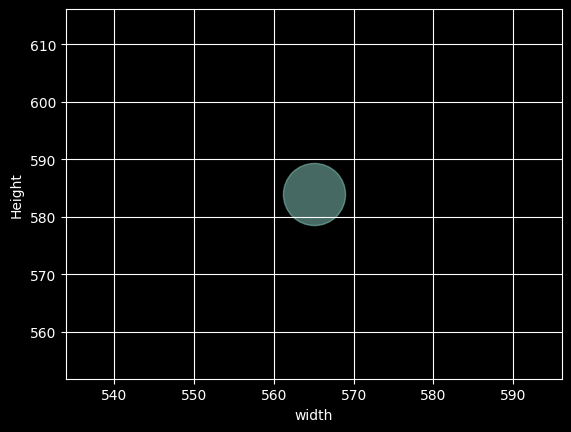

In [103]:
Dict = {}
for images in [train_images , test_images , val_images]:
    for image in images:
        im_shape = image.shape[:2]
        if(im_shape not in Dict.keys()):
            Dict[im_shape]=0
        Dict[im_shape] +=1

arr = np.array(list (Dict.keys())) 
num = np.array(list(Dict.values()))

plt.scatter(arr[:,1],arr[:,0] , s=num *100 ,alpha=0.5)
plt.ylabel('Height')
plt.xlabel('width')
plt.grid()
plt.show()

In [104]:
Dict 

{(584, 565): 20}

In [105]:
factor = 32
im_h =  584
im_w = 565

desired_shape = ( int(( im_h//factor )* factor) , int((im_w//factor) *factor) )
# desired_shape = (512,512)
config['dataset']['_image_shape'] = desired_shape

def  resize_images_to_numpy(Data ):
    List = []
    for image in tqdm(Data):
        # print(image.dtype)
        new_image = np.array(Image.fromarray(image).resize((desired_shape[1],desired_shape[0])))
        List.append(new_image)
        
    return np.array(List , dtype = np.float32)
    
def  resize_masks_to_numpy(Data):
    List = []
    for mask in tqdm(Data): ## implies RGB
        new_mask = Image.fromarray(mask).resize((desired_shape[1],desired_shape[0]))
        if( np.array(new_mask).ndim == 3):
            new_mask = np.arranp.sum(new_mask , axis=-1,keepdims=True)
        else: ## Implies  Graysclae
            new_mask = np.expand_dims(new_mask, axis = -1)
        
        new_mask = np.where(new_mask > 0 ,1 ,0)
    
        List.append(new_mask)
    return np.array(List , dtype = np.float32)

train_images = resize_images_to_numpy(train_images )
train_masks  = resize_masks_to_numpy(train_masks )

test_images = resize_images_to_numpy(test_images )
test_masks  = resize_masks_to_numpy(test_masks )

val_images = resize_images_to_numpy(val_images )
val_masks  = resize_masks_to_numpy(val_masks )

100%|██████████| 2/2 [00:00<00:00, 80.22it/s]


## > Preprocessing (only form images) & Datasplit

In [106]:
def image_01float_to_unit8(image_float):
    return (image_float*255).astype(np.uint8)
    
def image_clahe_gray(image , clipLimit  = 10 , tileGridLen = 10):
    clahe = cv2.createCLAHE(clipLimit=clipLimit , tileGridSize= (tileGridLen,tileGridLen) )
    # print(np.shape(image))
    # print(np.max(image) , np.array(image).dtype)
    clahe_image = clahe.apply(image)
    
    return clahe_image
# //---------------------------------------------------------------------------------------------------------------
def morphological_operations(image, kernel_size = 15,channel = 1):
    # Convert RGB image to grayscale
    # grayscale_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY)
    if( np.ndim(image)==3):
        grayscale_image = image[...,channel]
    else :
        grayscale_image = image
        # grayscale_image_cl = image_clahe_gray(grayscale_image,4,16)
    # Apply morphological operations (Top-hat filtering)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    tophat_result = cv2.morphologyEx(grayscale_image, cv2.MORPH_TOPHAT, kernel)
    return tophat_result
    
# Apply gamma correction-----------------------------------------------------------------------------------
def image_gamma_corr( image , gamma = 1.5): ## Uint8 .
    std_image = image_standarize(image)
    
    corrected_image = np.power(std_image , 1/gamma)
    # Convert back to uint8 format
    corrected_image_uint8 = (corrected_image * 255).astype(np.uint8)
    return corrected_image_uint8
# ///-----------------------------------------------------------------------------------------------------------------
from skimage.filters import frangi

def frangi_vessel_enhancement(image , alpha = 0.5 ,beta=0.5, gamma=1 ,kernel_size = 5,channel = 1):
    # Convert RGB image to grayscale
    if(np.ndim(image) == 3):
        # grayscale_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY)
        grayscale_image = image[...,channel]
    else :
        grayscale_image = image
    # Apply Frangi filter
    frangi_result = frangi(grayscale_image ,alpha = alpha ,beta=beta ,gamma = gamma ,) 
    frangi_result =  image_01float_to_unit8(frangi_result)
    # frangi_result = frangi(grayscale_image.
    blurred = cv2.GaussianBlur(frangi_result  , (kernel_size , kernel_size ), 0)  # Kernel size (5, 5), sigma = 0
    return blurred 
# ///-----------------------------------------------------------------------------------------------------------------
def image_normalise(image):  # for any type of images 
    mean = np.mean(image, axis=(0, 1))
    std_dev = np.std(image, axis=(0, 1))
# Normalize image
    normalised_image = (image - mean) / std_dev
    return normalised_image
    
def clip_image(image , clip_range =[0,2]): # for any type of images
    normalised_image = image_normalise(image)
    clip_image = np.clip( normalised_image, *clip_range)
    clip_std_image = (clip_image - clip_range[0] )/ (clip_range[1]-clip_range[0])
    clip_image = image_01float_to_unit8(clip_std_image)
    return clip_image

# //--------------------------------------------------------------------------------------------------
def  image_standarize(image_float): ## for all type of image
    # Calculate mean and standard deviation for each channel
    min_ = np.min(image_float, axis=(0, 1))
    max_ = np.max(image_float, axis=(0, 1))
    # Normalize image
    standarized_image = (image_float - min_) / (max_ - min_)
    return standarized_image 

In [107]:
num = 4
func_Dict ={
    'clahe' :image_clahe_gray,
    'gamma_correction':image_gamma_corr,
    'morphological_operations':morphological_operations,
#     'frangi_vessel_enhancement' : frangi_vessel_enhancement,
    'norm_clip': clip_image,
}

In [108]:
param_Dict = {'clahe': {'clipLimit': np.array([ 4,  8, 12, 16]),
           'tileGridLen': np.array([17, 27, 28, 31])},
 'gamma_correction': {'gamma': np.array([0.5, 0.6, 0.7, 0.8])},
 'morphological_operations': {'kernel_size': np.array([100, 133, 166, 200])},
 'norm_clip': {'clip_range': np.array([[ 0.  ,  2.  ],
       [ 0.  ,  2.5 ],
       [ 0.  ,  3.  ],
       [ 0.25,  2.25],
       [-0.25,  2.  ]])}}

In [109]:
# param_Dict = {
#     'clahe' : {
#         'clipLimit' : np.linspace(4,16,num).astype('int'),
#         'tileGridLen' : np.random.randint(16,32,(num,),)
#    },
    
#      'gamma_correction':{
#         'gamma' :np.linspace(0.5,0.8,num),
#     },
    
#      'morphological_operations':{
#         'kernel_size' :np.linspace(100,200,num).astype('int'),
#     },
# #      'frangi_vessel_enhancement':{
# #         'kernel_size': 2* np.random.randint(0,2,(num,))+1,
# #         'gamma':np.random.uniform(0.5,2.5,(num,))
# #     },
#     'norm_clip':{
#         'clip_range':np.array([[0,2],[0,2.5] ,[0,3],[0.25,2.25],[-0.25,2]])
#     },
# }
# pprint(param_Dict)

In [110]:
theta = 50
def concat_aug(image):
    image_List = []
    
    image = np.array(image,dtype=np.uint8)
    
    image_roi = np.where(np.max(image,axis =-1) > theta ,1,0)
    
    # image_List.append(image_roi)
    image_List.append(image[...,0])
    image_List.append(image[...,1])
    image_List.append(image[...,2])
    image_green = image[...,1]
    
#     display_image(image_roi)
    
    for op_name , func in func_Dict.items():
        
        for j in range(num):
            Dict = {}
            for param , vals in param_Dict[op_name].items():
                Dict[param] = vals[j]
                
        ##  will focus on green pixel only 
            img = func(image_green,**Dict)
            # print( op_name , np.max(img),np.shape(img))
            image_List.append(img*image_roi)
            
    image_array = np.moveaxis(image_List ,0, -1)
    return image_array 
    
def Augment_train(X):
    X_new = []
    for image in tqdm(X):
        new_image_set = concat_aug(image)        
        X_new.append(new_image_set)
    return np.array(X_new , dtype = 'uint8')

In [111]:
%time train_images = Augment_train(train_images)
%time test_images = Augment_train(test_images)
%time val_images = Augment_train(val_images)

100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


CPU times: total: 21.5 s
Wall time: 24.8 s


100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


CPU times: total: 5.67 s
Wall time: 5.55 s


100%|██████████| 2/2 [00:03<00:00,  1.51s/it]

CPU times: total: 3.09 s
Wall time: 3.07 s


In [112]:
 train_images.shape ,test_images.shape , val_images.shape

((14, 576, 544, 19), (4, 576, 544, 19), (2, 576, 544, 19))

In [113]:
# shape = (600,600)
# def Reshape(image):
#     # try:
#     #     image = Image.fromarray(image)
#     #     return np.array(image.resize(shape))
#     # except Exception as e:
#     #     print(e)
#     return image

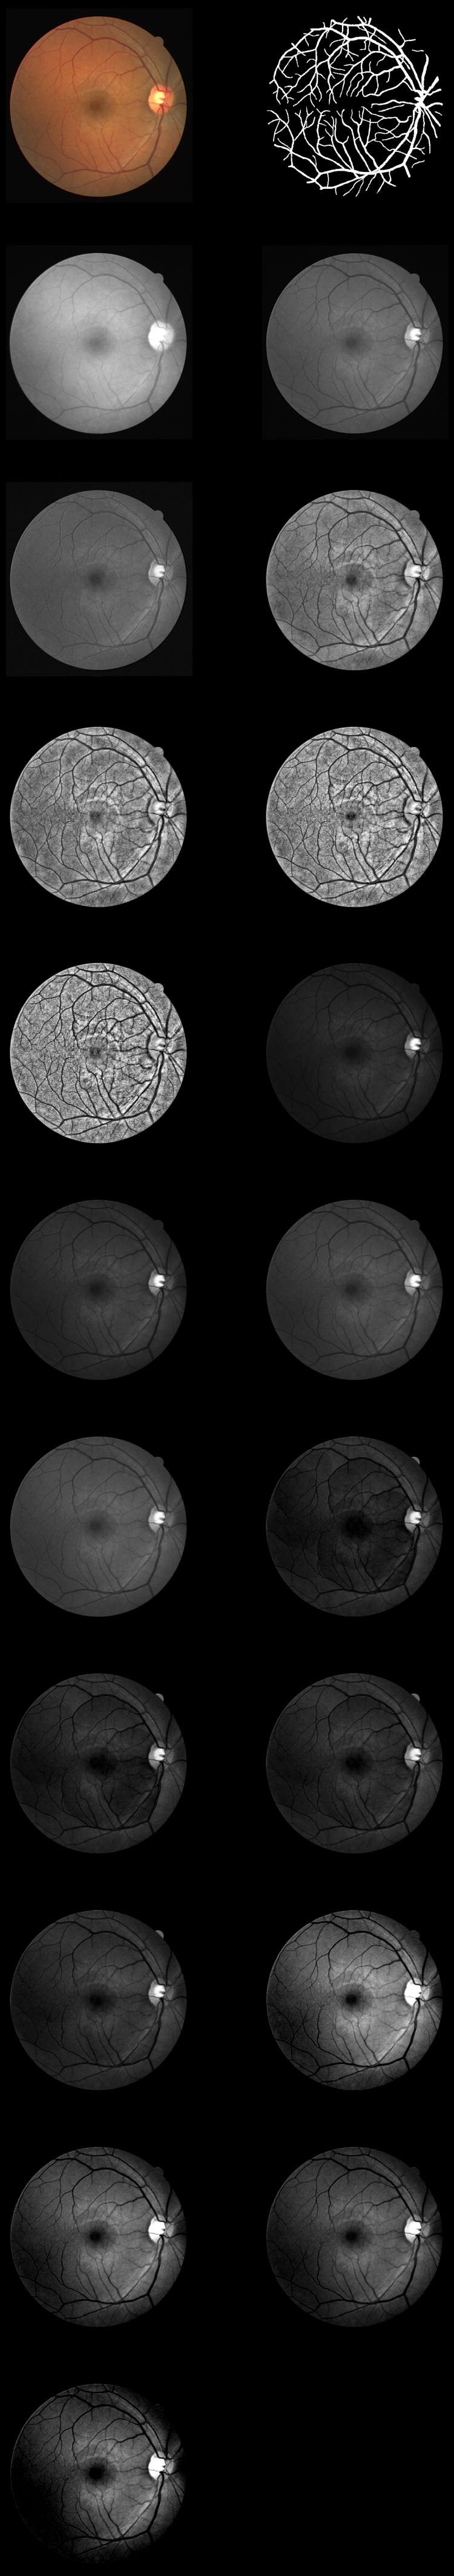

In [114]:
index = 2
List = [Reshape(test_images[index][...,:3]),Reshape(test_masks[index][...,0]),]
num = 19
for i in range(num):
    List.append(Reshape(test_images[index][...,i]))

display_images(List,cmap = 'gray',size = 5,grid=(11,2),)

## > Model Building & importing

### > get the base Models

In [25]:
# !pip install segmentation_models

os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [ ]:
# !pip install keras_unet_collection

In [ ]:
# from keras_unet_collection import models as unet_models
# from keras_unet_collection import losses as unet_losses

In [24]:
config['dataset']['_image_shape'] = desired_shape

In [ ]:
# num = 0
# model_name = Model_names[0]
# # backbone_name ='EfficientNetB0'
# # backbone_name ='efficientnetb0'

# image_shape =  config['dataset']['_image_shape'] 

In [33]:
# os.listdir()

In [34]:
import sys

sys.path.append( "MyKerasLiberary") 

import unet_models as unet_models

In [51]:
num = 1
model_name = Model_names[num]
image_shape =  config['dataset']['_image_shape'] 
n_channel = train_images[0].shape[-1]


unet_models.General_Config['image_shape']= image_shape
unet_models.General_Config['n_channel']= n_channel
unet_models.Model_Config['n_level'] = 4
unet_models.Model_Config['n_unit'] = 32
unet_models.Model_Config['dilation'] = 1

Model = unet_models.BuildUnet(num = num)

In [52]:
# model_name = Model_names[4]
# image_shape =  config['dataset']['_image_shape'] 
# n_channel = train_images[0].shape[-1]


# unet_models.General_Config['image_shape']= image_shape
# unet_models.General_Config['n_channel']= n_channel
# unet_models.Model_Config['n_level'] = 4
# unet_models.Model_Config['n_unit'] = 32
# unet_models.Model_Config['dilation'] = 1

# Model = unet_models.BuildUnet(num = 0 , has_attention=True)

In [53]:
models.clone_model(Model)

<Functional name=Unet_Model, built=True>

In [54]:
Model.summary()

Model: "Unet_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 576, 544,  │          0 │ -                 │
│ (InputLayer)        │ 20)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_56 (Conv2D)  │ (None, 576, 544,  │        672 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 576, 544,  │      9,248 │ conv2d_56[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 576, 544,  │        128 │ conv2d_57[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_38       │ (None, 576, 544,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_58 (Conv2D)  │ (None, 576, 544,  │      9,248 │ activation_38[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 576, 544,  │        128 │ conv2d_58[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_39       │ (None, 576, 544,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 576, 544,  │          0 │ activation_39[0]… │
│                     │ 32)               │            │ conv2d_56[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_59 (Conv2D)  │ (None, 576, 544,  │      9,248 │ add[0][0]         │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 576, 544,  │        128 │ conv2d_59[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_40       │ (None, 576, 544,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 288, 272,  │          0 │ activation_40[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 288, 272,  │      2,112 │ max_pooling2d_8[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 288, 272,  │     36,928 │ conv2d_60[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 288, 272,  │        256 │ conv2d_61[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_41       │ (None, 288, 272,  │          0 │ batch_normalizat

 Total params: 12,237,729 (46.68 MB)

 Trainable params: 12,228,897 (46.65 MB)

 Non-trainable params: 8,832 (34.50 KB)

In [ ]:
# def get_segmentation_model_0():
#     n_class = 1
#     BaseModel = sm.Unet(backbone_name = backbone_name , 
#                                     input_shape = image_shape+(3,),
#                                     encoder_weights='imagenet',
#                                      classes=1,
#                                     activation = 'sigmoid',
#                                     encoder_freeze = True,
#                                     decoder_block_type ='upsampling',
#                                    )
#     return BaseModel
# def get_segmentation_model_1():
#     Model = unet_models.unet_2d(image_shape+(3,) ,
#                             n_labels = 1,
#                             filter_num=[32,64,128,256,512],
#                             output_activation='Sigmoid',
#                             weights='imagenet',
#                             # name = 'my_unet',
#                             batch_norm=True,
#                             backbone=backbone_name,
#                             freeze_backbone=True,
#               )
#     return Model
# def get_segmentation_model_2():
#     Model = unet_models.r2_unet_2d(image_shape + (3,),
#                                n_labels = 1,
#                                 filter_num=[32,64,128,256,512],
#                                output_activation='Sigmoid',
#                                # weights='imagenet',
#                                 # name = 'my_unet',
#                                batch_norm=True,
#                                 # backbone='bacbackbone_name,
#                             # freeze_backbone=True,
#               )
#     return Model
# def get_segmentation_model_3():
#     Model = unet_models.att_unet_2d(image_shape+(3,) ,
#                                n_labels = 1,
#                                filter_num=[32,64,128,256,512],
#                                output_activation='Sigmoid',
#                                # weights='imagenet',
#                                # name = 'my_unet',
#                                batch_norm=True,
            
#                                 # backbone = backbone_name,
#                             # freeze_backbone=True,
#               )
#     return Model
# def get_segmentation_model_4():
#     Model = unet_models.unet_3plus_2d(
#                                 image_shape+(3,) ,
#                                 n_labels = 1,

#                                 filter_num_down=[32,64,128,256,512],
#                                 # filter_num_up=[32,64,128,256,512],
#                                output_activation='Sigmoid',
#                                backbone='EfficientNetB0',
#                                weights='imagenet',
#                                 batch_norm=True,
#                                 # name = 'my_unet',
#                                 freeze_backbone=True,
#                                 filter_num_skip = [64,]*4,
#               )
#     return Model

### > build Model 

In [ ]:
# sm.get_preprocessing(backbone_name)(image)

In [29]:
# Model = get_segmentation_model_0()
# Model.summary(100)

In [ ]:
# n_unit = 8
# dilation = 2 
# n_channel = 18 
# fn_input = layers.Input(shape = image_shape + (n_channel,))
# x_rescale = layers.Rescaling(1/255.)(fn_input)

# x1 = layers.Conv2D(n_unit,kernel_size  = 1 ,strides=1,padding= 'same',kernel_initializer= 'ones',activation = 'tanh')(x_rescale)
# x2 = layers.Conv2D(n_unit,kernel_size  = 2 ,strides=1,dilation_rate = dilation, padding= 'same',kernel_initializer= 'ones',activation = 'tanh')(x_rescale)
# x3 = layers.Conv2D(n_unit,kernel_size  = 3 ,strides=1,dilation_rate = dilation ,padding= 'same',kernel_initializer= 'ones',activation = 'tanh')(x_rescale)
# # x3  = layers.Conv2D(1,kernel_size  = 5 ,strides=1,padding= 'same',kernel_initializer= 'ones',activation = 'relu')(fn_input
# x_add = layers.Add()([x1,x2,x3]) 
# x_add = layers.BatchNormalization()(x_add)

# x4 = layers.Conv2D(n_unit,kernel_size  = 3 ,strides=1,padding= 'same',kernel_initializer= 'ones',activation = 'tanh')(x_add)
# x5 = layers.Conv2D(n_unit,kernel_size  = 1 ,strides=1,padding= 'same',kernel_initializer= 'ones',activation = 'tanh')(x_rescale)

# x_add = layers.Add()([x4,x5]) 
# x_add = layers.BatchNormalization()(x_add)

# x6 = layers.Conv2D(4,kernel_size  = 3 ,strides=1,padding= 'same',kernel_initializer= 'ones',activation = 'relu')(x_add)
# x_add = layers.BatchNormalization()(x_add)

# fn_output = layers.Conv2D(1,kernel_size  = 3 ,strides=1,padding= 'same',kernel_initializer= 'ones',activation = 'sigmoid')(x6)

# # fn_output  = Model(x1)
# pre_Model = models.Model(inputs = fn_input , outputs =fn_output,name = 'model_base')

# pre_Model.summary(100)
# models.clone_model(pre_Model)

In [ ]:
# n_unit = 8
# dilation = 2 
# n_channel = 18 
# fn_input = layers.Input(shape = image_shape + (n_channel ,))

# x1 = layers.Conv2D(n_unit, kernel_size  = 1 ,strides=1,padding= 'same',kernel_initializer= 'ones',activation = 'relu')(fn_input)
# x2 = layers.Conv2D(n_unit,kernel_size  = 2 ,strides=1,dilation_rate = dilation ,padding= 'same',kernel_initializer= 'ones',activation = 'relu')(fn_input)
# x3  = layers.Conv2D(n_unit,kernel_size  = 3 ,strides=1,dilation_rate = dilation ,padding= 'same',kernel_initializer= 'ones',activation = 'relu')(fn_input)
# x_add = layers.Add()([x1,x2,x3]) 
# x4 = layers.Conv2D(n_unit,kernel_size  = 3 ,strides=1,padding= 'same',kernel_initializer= 'ones',activation = 'relu')(x_add)

# x_out = un_model_1(fn_input)
# x_conc =  layers.Concatenate()([x_out*255 , x_add])

# x6 = layers.Conv2D(4,kernel_size  = 3 ,strides=1,padding= 'same',kernel_initializer= 'ones',activation = 'relu')(x_conc)
# x6 = layers.Conv2D(3,kernel_size  = 3 ,strides=1,padding= 'same',dilation_rate = dilation ,kernel_initializer= 'ones',activation = 'relu')(x6)

# # fn_output  = Model(x1)
# prev_Model = models.Model(inputs = fn_input , outputs = x6,name = 'model_base')

# prev_Model.summary(100)
# models.clone_model(prev_Model)

In [ ]:
# n_unit = 8
# dilation = 2 
# n_channel = 13 
# fn_input = layers.Input(shape = image_shape + (n_channel,))
# # x_rescale = layers.Rescaling(1/255.)(fn_input)
# x_rescale = fn_input

# x1 = layers.Conv2D(n_unit,kernel_size  = 1 ,strides=1,padding= 'same',activation = 'tanh')(x_rescale)
# x2 = layers.Conv2D(n_unit,kernel_size  = 2 ,strides=1,dilation_rate = dilation, padding= 'same',activation = 'tanh')(x_rescale)
# x3 = layers.Conv2D(n_unit,kernel_size  = 3 ,strides=1,dilation_rate = dilation ,padding= 'same',activation = 'tanh')(x_rescale)
# # x3  = layers.Conv2D(1,kernel_size  = 5 ,strides=1,padding= 'same',kernel_initializer= 'ones',activation = 'relu')(fn_input
# x_add = layers.Add()([x1,x2,x3]) 
# # x_add = layers.BatchNormalization()(x_add)

# x4 = layers.Conv2D(n_unit,kernel_size  = 3 ,strides=1,padding= 'same',activation = 'relu')(x_add)
# x5 = layers.Conv2D(n_unit,kernel_size  = 1 ,strides=1,padding= 'same',activation = 'relu')(x_rescale)

# x_add = layers.Add()([x4,x5]) 
# # x_add = layers.BatchNormalization()(x_add)

# x6 = layers.Conv2D(4,kernel_size  = 3 ,strides=1,padding= 'same',activation = 'relu')(x_add)
# # x6 = layers.BatchNormalization()(x6)

# fn_output = layers.Conv2D(3,kernel_size  = 3 ,strides=1,padding= 'same')(x6)

# # fn_output  = Model(x1)
# prev_Model = models.Model(inputs = fn_input , outputs =fn_output,name = 'model_base')

# prev_Model.summary(100)
# models.clone_model(prev_Model)

In [ ]:
# un_model_1 = pre_Model
# un_model_1.set_weights(Unet_Model.get_weights())

In [ ]:
# un_model_2 = pre_Model
# un_model_2.set_weights(un_model_1.get_weights())

In [ ]:
# Unet_Model = models.Sequential([prev_Model,Model])
# Unet_Model.summary()
# models.clone_model(Unet_Model)

In [ ]:
# Unet_Model = pre_Model
# Unet_Model = Model

In [ ]:
# Unet_Model(np.zeros(shape = (1,)+image_shape+ (28,))).shape

## > Model Training 

In [ ]:
model_weights_path1 = 'unet_model_best1.weights.h5'
model_weights_path2 = 'unet_model_best2.weights.h5'
model_weights_path3 = 'unet_model_best3.weights.h5'
model_weights_path4 = 'unet_model_best4.weights.h5'
model_weights_path5 = 'unet_model_best5.weights.h5'
model_weights_path6 = 'unet_model_best6.weights.h5'


checkpoint_callback = callbacks.ModelCheckpoint(  ## To save Best Models
    model_weights_path1,
    monitor = 'val_loss',
    verbose = 1,
    save_best_only = True, ## will save best weights. 
    save_weights_only = True, ## If false will save whole model .. .
    mode = 'auto', # if monitor val_loss that it will be min else if val_accuracy that it will be Max..
    save_freq = 'epoch', ## we will do this after every epoch .
)

plateau_callback = callbacks.ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.6, ## reduce by this factor . ## lr = lr*0.1
    patience = 5, ## wait till these number of epochs ,
    verbose = 1,
    mode = 'auto', ## similar to what studied above,,i..e Min or Max..
    min_delta = 0.0, ## if change is less than delta than we will consider it as no improvement . 
    cooldown = 0,  ## to wait after we have updated our lr ,,
    min_lr = 0, ## dont go below this lr.
)

In [ ]:
# os.removedirs(base_path + 'liberary')

In [81]:
# dice_loss = sm.losses.DiceLoss()
# focal_loss = sm.losses.BinaryFocalLoss()
# bce_loss = sm.losses.BinaryCELoss()
# jaccard_loss = sm.losses.JaccardLoss()
# hybrid_loss1 = dice_loss + 1.*(focal_loss)
# hybrid_loss2 = dice_loss + 1.*(bce_loss) + 1.*jaccard_loss
# hybrid_loss3 = jaccard_loss + bce_loss
# # loss = dice_loss
# # loss = hybrid_loss1
# # loss = bce_loss
# # loss = focal_loss
loss = sm.losses.JaccardLoss()
# # loss = sm.losses.binary_focal_jaccard_loss
# # loss = hybrid_loss3

In [82]:
def specificity(y_true, y_pred):
    tn = tf.keras.backend.sum(tf.keras.backend.cast((1 - y_true) * (1 - y_pred), 'float32'))
    total_background = tf.keras.backend.sum(1 - y_true)
    return tn / (total_background + tf.keras.backend.epsilon())

def sensitivity(y_true, y_pred):
    tp = tf.keras.backend.sum(tf.keras.backend.cast(y_true * y_pred, 'float32'))
    total_foreground = tf.keras.backend.sum(y_true)
    return tp / (total_foreground + tf.keras.backend.epsilon())

# Assuming y_true and y_pred are segmentation masks with values in {0, 1} for background and foreground, respectively
# Compute specificity and sensitivity
# spec = specificity(y_true, y_pred)
# sens = sensitivity(y_true, y_pred)

In [151]:
metrics_ = [
            # metrics.MeanIoU(num_classes=2 , name = 'mean_iou_score') ,
            sm.metrics.IOUScore(name = 'iou_score',),
            'accuracy', 
            sm.metrics.FScore(name = 'f1score'),
            metrics.AUC(name = 'auc',),
            # metrics.BinaryIoU(name='binary_iou'),
            specificity,
            sensitivity
           ]

lr = 0.005
Model.compile(
    optimizer = optimizers.Adam(learning_rate=lr),
    loss = loss,
    metrics = metrics_,
)

In [ ]:
History = {}
def add_to_history(history):
    for metric,values  in history.history.items():
        if(metric not in History.keys()):
            History[metric] = []
        History[metric] += values

### Augmentatiion

In [ ]:
transform = A.Compose(
    [
        A.HorizontalFlip(p = 0.5),
        A.VerticalFlip(p = 0.5),
    ]
)

def Augment_it(X_train ,Y_train,rescale = False):
    Image_List = []
    Mask_List = []
    for image , mask  in zip(X_train,Y_train):
        Dict = { 'image':image,
                        'mask':mask ,}
        trans_data = transform(**Dict)
        
        Image_List.append(trans_data['image'])
        Mask_List.append(trans_data['mask'])
    
    Image_List = np.array(Image_List)         
    Mask_List = np.array(Mask_List)         
    
    if(rescale):
        Image_List/=255.
    return Image_List,Mask_List

In [ ]:
num_ = 12
index = 1
for i in range(num_):
    X_train,Y_train =Augment_it(train_images[:1],train_masks[:1])
    display_images([train_images[0][...,index],train_masks[0] ,X_train[0][...,index],Y_train[0]] ,size = 4,cmap = 'gray')

### Training

In [66]:
batch_size = 2

# back_bone_name =  'efficientnetb0' 
# preprocess = sm.get_preprocessing(back_bone_name)

indexes = np.arange(train_images.shape[0])
patience = 5
temp_wait = 0
factor = 0.5
lr_scale = 1.2
monitor = 'val_loss'
best_monitor_value = 1234647  

In [ ]:
n_epoch = 150

for epoch in tqdm(range(n_epoch)):
    indexes = np.random.permutation(indexes)

    X_train ,Y_train = train_images[indexes] , train_masks[indexes] 
    X_train ,Y_train = Augment_it(X_train ,Y_train )
    
    ## preprocessing .......................................................................................................
    # X_train = preprocess(X_train)
    # X_val = preprocess(val_images)
    
    ## Plateau Callback .....................................................................................................
    if(monitor in History.keys()) :
        # print(temp_wait ,History[monitor][-1] , best_monitor_value)
        if (History[monitor][-1] < best_monitor_value):
            best_monitor_value = History[monitor] [-1]
            temp_wait = patience
        else:
            if(temp_wait > 0):
                temp_wait -= 1
            else:
                prev_lr =np.array(Model.optimizer.learning_rate)
                new_lr = (prev_lr) * factor
                setattr(Model.optimizer, 'learning_rate',new_lr)
                print(f">>>>>>>> | Changing Learning Rate from {prev_lr} to {new_lr}")
                
                patience = int(patience * lr_scale)
                temp_wait = patience
    print('>>>>>>>> | Learning is :', np.array(Model.optimizer.learning_rate),"| Patience is",patience ,'| temp_wait is',temp_wait)
    # ///----------------------------------------------------------------------------------------
    history = Model.fit(
                X_train,
                Y_train,
                
                validation_data=[val_images ,val_masks],
                epochs  = 1,
                batch_size = batch_size,
                callbacks=([checkpoint_callback , 
#                             plateau_callback,
                           ]
                        ),
                shuffle = False,
        
                )
    add_to_history(history)

In [ ]:
# np.max(val_masks[0])

In [ ]:
# setattr(Model.optimizer, 'learning_rate',0.0001)
# patience = 8

In [ ]:
# Model.trainable=True

In [ ]:
# Model_dict = {}
# History_dict = {}

In [ ]:
# Model_dict

In [ ]:
# add_to_history_dict( History, model_name)
# add_to_model_dict( Model ,model_name)

## > Analysing and Ploting Results

In [44]:
# np.array(Model.optimizer.learning_rate)
os.listdir('Models/Drive/')

['r2_unet.keras',
 'recuurent.keras',
 'residual_attention_unet.keras',
 'residual_unet.keras',
 'simple_unet.keras']

In [148]:
Model = models.load_model('Models/Drive/residual_attention_unet.keras',compile=False)

In [149]:
# Model.load_weights(model_weights_path1)

In [152]:
train_result  =  Model.evaluate(train_images,train_masks ,return_dict=True , batch_size=batch_size)
val_result =  Model.evaluate(val_images,val_masks ,return_dict=True , batch_size=batch_size) 
test_result  =  Model.evaluate(test_images,test_masks, return_dict=True ,batch_size=batch_size)

7/7 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.9617 - auc: 0.9210 - f1score: 0.8358 - iou_score: 0.7181 - loss: 0.2819 - sensitivity: 0.8187 - specificity: 0.9810
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9598 - auc: 0.9251 - f1score: 0.8201 - iou_score: 0.6951 - loss: 0.3049 - sensitivity: 0.8350 - specificity: 0.9751
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 5s/step - accuracy: 0.9580 - auc: 0.9226 - f1score: 0.8237 - iou_score: 0.7003 - loss: 0.2997 - sensitivity: 0.8264 - specificity: 0.9755


In [153]:
# Model.save_weights(model_weights_path5)

In [154]:
# pprint(val_result )
# print()
# pprint(train_result)
# print()
# pprint(test_result)

In [155]:
val_pd = pd.DataFrame(val_result,index=['validation'])
test_pd = pd.DataFrame(test_result,index=['testing'])
train_pd = pd.DataFrame(train_result,index=['training'])

result = pd.concat([train_pd , val_pd,test_pd])
result

,accuracy,auc,f1score,iou_score,loss,sensitivity,specificity
training,0.960194,0.922131,0.832230,0.712872,0.287128,0.823327,0.978785
validation,0.959762,0.925130,0.820138,0.695114,0.304886,0.834996,0.975079
testing,0.957974,0.926009,0.827000,0.705154,0.294846,0.833548,0.974791


### > training Plot

In [156]:
# # model_name = "unet"
# # History = History_dict[ model_name]

# metric_List = list(History.keys())


# plt.figure(figsize = (16,16),facecolor='#301934').suptitle(model_name+" Performance",fontsize=16, y=0.90)
# for i,metric in enumerate(metric_List[:7],1):
#     plt.subplot(4,2,i)
#     plt.plot(History[metric],label='train',linewidth=2)
#     plt.plot(History['val_'+ metric],label='validation',linewidth=1.5)
#     plt.title(metric)
#     plt.legend()
#     plt.ylabel(metric + ' -->')
#     plt.xlabel('epoch -->')
#     plt.subplots_adjust(wspace=0.2, hspace=0.3) 
#     plt.grid()
# plt.show()

### > comparision plot

### > Sample Predictions

In [157]:
def get_pred_mask(image):
    return Model.predict(tf.expand_dims(image,axis=0),verbose=0)[0]

In [158]:
# def get_aug_image(image):
#     mask_pred_1 = get_pred_mask(image)
    
#     mask_pred_2 = get_pred_mask(np.fliplr(image))
#     mask_pred_2 = np.fliplr(mask_pred_2)
    
#     mask_pred_3 = get_pred_mask(np.flipud(image))
#     mask_pred_3 = np.flipud(mask_pred_3)
    
#     # mask_pred_4 = get_pred_mask(np.flipud(np.fliplr(image)))
#     # mask_pred_4 = np.flipud(np.fliplr(mask_pred_4))
    
#     mask_pred_aug = (mask_pred_1 + mask_pred_2 + mask_pred_3 )/3
#     return mask_pred_1 ,mask_pred_aug

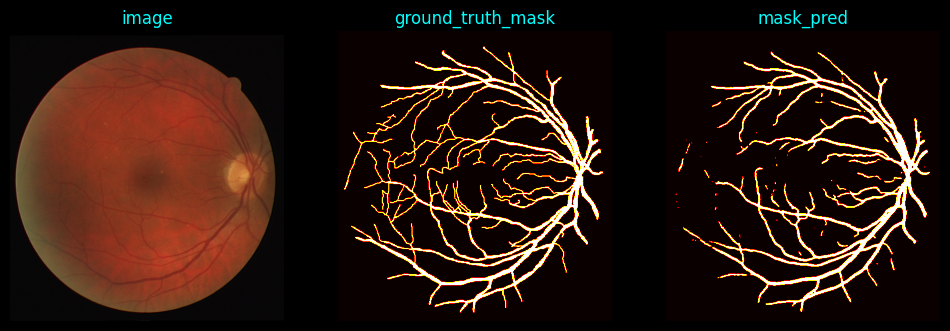

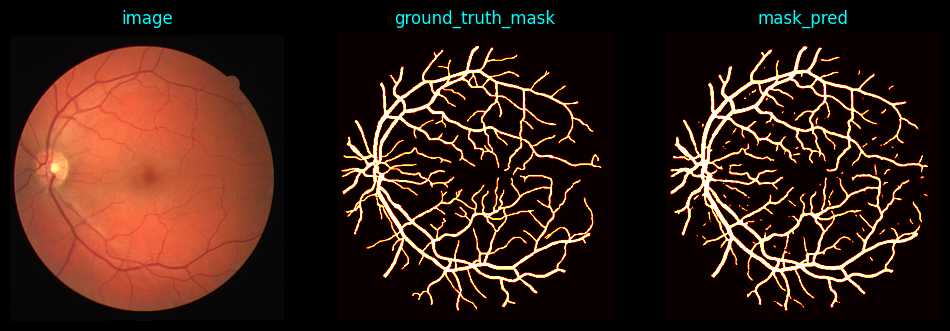

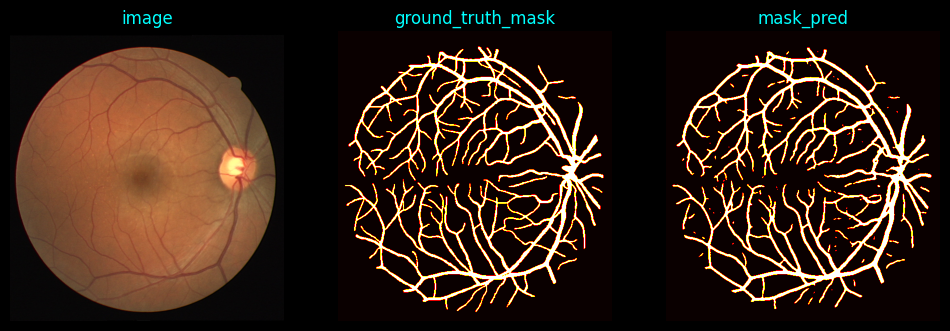

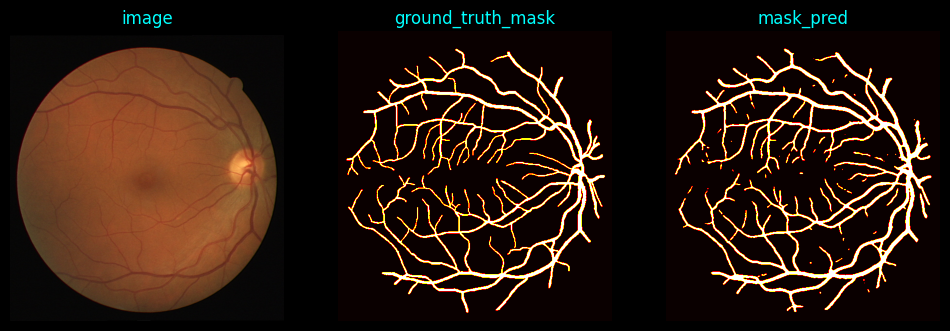

In [159]:
threshold = 0.5
for image , mask in zip(test_images , test_masks):
# for image , mask in zip(test_images , test_masks):
    
#     print(image.min() ,image.max() , mask.min() ,mask.max())
    # mask_pred , mask_pred_aug = get_aug_image(image)
    mask_pred = get_pred_mask(image)
    mask_pred = (mask_pred>threshold)
    # mask_pred_aug = (mask_pred_aug > threshold)
        
    image = (image-image.min()) / (image.max()-image.min()) 
    
    display_images([image[...,:3] ,mask,mask_pred],['image','ground_truth_mask','mask_pred','mask_pred_aug'],size = 4,cmap='hot')

In [ ]:
# np.max(new_image)

In [ ]:
# new_image = prev_Model(train_images[index:index+1])[0]
# display_images([train_images[index][...,:3],new_image ,train_masks[index],],cmap = 'gray',size = 6,scaling='minmax',grid=(1,3))

In [ ]:
### def image_gaus_edge(image,thresh1= 50 , kernel_size = 5,channel = None):
    # Convert the image to grayscale
    # gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    if(np.ndim(image)==3):
        if(channel):
            gray =  image[...,channel]
        else :
            gray = cv2.cvtColor(image , cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    # print(np.shape(image))
    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(gray, (kernel_size , kernel_size ), 0)  # Kernel size (5, 5), sigma = 0
    # Apply edge detection using Canny
    edge = cv2.Canny(blurred, threshold1=thresh1, threshold2=100)  # Adjust thresholds as needed

    return edge

In [ ]:
min_ = np.min(new_image ,axis = (0,1))
max_ = np.max(new_image ,axis = (0,1)) 

new_image = 255*(new_image - min_) /( max_ - min_)
new_image = np.array( new_image , dtype ='uint8')

In [ ]:
img_edge_1= image_gaus_edge(new_image, 300,3,channel=1)
img_edge_2= image_gaus_edge(new_image, 100,5,channel=0)
display_images([img_edge_1,img_edge_2,new_image,train_masks[index]] ,size=5,cmap = 'gray' , grid=(3,2))

## > Saving Results

In [ ]:
# [ 'pretrained_unet' ,'residual_unet' ,'r2_unet' , 'residual_attention_aunet']

In [ ]:
import json

In [ ]:
with open(base_path+'dataset/account_content','r') as file:
    content = file.read()
Folder_key_dict  = json.loads(content)
# Address_dict

In [ ]:
# pip install mediafire

In [ ]:
from mediafire import MediaFireApi
from mediafire import MediaFireUploader
api = MediaFireApi()
uploader = MediaFireUploader(api)

In [ ]:
def upload_models():
    base_path = 'Models' 
    try:
        os.mkdir(base_path)
    except:
        pass
        
    folder_key = Folder_key_dict['EyeSegmentation'][dataset_name][base_path]['folder_key']
    print(folder_key)
    
    for model_name , model in Model_dict.items():
        model_save_path = base_path + '/' + model_name + '.keras'
        model.save(model_save_path)

#         session = api.user_get_session_token(
#                         email='prajwalsharma.bt21cse@pec.edu.in',
#                         password='Praju@321',
#                         app_id='42511',
#         )
        
#         api.session = session
    
#         try:
#             print(model_name ,'upload started >>>')
#             with open(model_save_path ,'rb') as model_file:
#                 uploader = MediaFireUploader(api)
#                 %time result = uploader.upload(model_file , model_name , folder_key=folder_key)
#             print(model_name ,'uploaded successfully')
#             print('------------------------------------------------------------------------------------')
#         except Exception as e:
#             print("Error :",e)

In [ ]:
def upload_Dict(Dict , dict_name = 'history_dict'):
    base_path = 'Meta' 
    try:
        os.mkdir(base_path)
    except:
        pass
    
    folder_key = Folder_key_dict['EyeSegmentation'][dataset_name][base_path]['folder_key']
    print(folder_key)
    
    dict_file_name = base_path + '/' + dict_name+'.txt'
    
    dict_str = dict_str = json.dumps(Dict)
    dict_str = dict_str.encode()
    with open(dict_file_name,'wb') as dict_file :
        dict_file.write(dict_str)

#     session = api.user_get_session_token(
#                     email='prajwalsharma.bt21cse@pec.edu.in',
#                     password='Praju@321',
#                     app_id='42511',
#     )
#     api.session = session

#     try:
#         with open(dict_file_name ,'rb') as dict_file:
#             dict_str2 = dict_file.read()
#             Dict2 = json.loads(dict_str2)
            
#             uploader = MediaFireUploader(api)
#             %time result = uploader.upload(dict_file , dict_name , folder_key=folder_key) 
    
#     except Exception as e:
#         print("Error :",e)

In [ ]:
upload_models()

In [ ]:
upload_Dict(History_dict)

In [ ]:
# Model = models.load_model('Models/pretrained_unet_keras',compile=False)
# Model.evaluate(test_images,test_masks)

In [ ]:
# with open('Meta/history_dict_.txt' ,'rb') as dict_file:
#     dict_str2 = dict_file.read()
# Dict2 = json.loads(dict_str2)
# Dict2

In [ ]:
api = MediaFireApi()
# uploader = MediaFireUploader(api)

session = api.user_get_session_token(
                email='prajwalsharma.bt21cse@pec.edu.in',
                password='Praju@321',
                app_id='42511',
)

## Test Results

In [125]:
import json

In [132]:
dict_file_name = 'Meta/Drive/history_dict1.txt'
with open(dict_file_name ,'rb') as dict_file:
    dict_str2 = dict_file.read()
    Dict2 = json.loads(dict_str2)
Dict2.keys()
    

dict_keys(['residual_attention_unet'])

In [131]:
dict_file_name = 'Meta/Drive/history_dict.txt'
with open(dict_file_name ,'rb') as dict_file:
    dict_str2 = dict_file.read()
    Dict2 = json.loads(dict_str2)
Dict2.keys()
    

dict_keys(['residual_unet', 'recuurent', 'r2_unet', 'simple_unet', 'residual_attention_unet'])